In [2]:
import MySQLdb as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
%matplotlib inline

name = 'DatabaseMain'
conn = db.connect(host = "localhost", user = "root", passwd ="", db=name)
cursor = conn.cursor()

sql = ''' SELECT G.DateTime, W.Room, R.Capacity, T.Module, M.NumReg, W.Associated, G.PercentageEstimate, G.BinaryEstimate
          FROM DatabaseMain.WiFiLogData W, DatabaseMain.GroundTruth G, DatabaseMain.Rooms R, DatabaseMain.TimeModule T,
          DatabaseMain.Modules M
          WHERE W.Room = G.Room AND W.DateTime BETWEEN G.DateTime AND DATE_ADD(G.DateTime, INTERVAL 1 HOUR) 
          AND R.Room = W.Room AND R.Room = G.Room AND T.Room = G.Room AND T.Room = R.Room AND T.Room =  W.Room 
          AND T.DateTime = G.DateTime AND M.ModuleName = T.Module
          ORDER BY G.DateTime'''
df = pd.read_sql_query(sql, conn)
df.head()



,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate
0,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0
1,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0
2,2015-11-03 09:00:00,B-002,90,None,0,4,0.00,0
3,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1
4,2015-11-03 09:00:00,B-002,90,None,0,21,0.00,0


In [6]:
df.describe()

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,133.333333,38.288569,30.284972,0.249101,0.687450,32.628897
std,61.294838,40.911113,28.965944,0.217957,0.463625,34.702654
min,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,0.000000,10.000000,0.000000,0.000000,0.000000
50%,90.000000,29.000000,22.000000,0.250000,1.000000,22.500000
75%,220.000000,60.000000,42.000000,0.250000,1.000000,55.000000
max,220.000000,143.000000,232.000000,1.000000,1.000000,220.000000


In [7]:
df.corr()

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
Capacity,1.000000,0.463803,0.307442,-0.043771,-0.059141,0.391415
NumReg,0.463803,1.000000,0.672959,0.348959,0.290459,0.563652
Associated,0.307442,0.672959,1.000000,0.561168,0.429123,0.697991
PercentageEstimate,-0.043771,0.348959,0.561168,1.000000,0.770780,0.818172
BinaryEstimate,-0.059141,0.290459,0.429123,0.770780,1.000000,0.634112
estimate,0.391415,0.563652,0.697991,0.818172,0.634112,1.000000


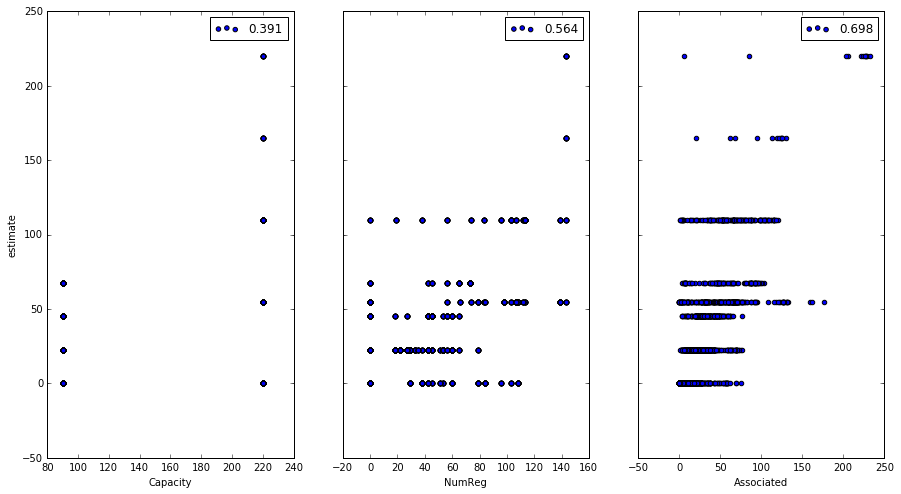

In [9]:
fig, axs = plt.subplots(1, 3, sharey = True)
df.plot(kind='scatter', x = 'Capacity', y = 'estimate', label="%.3f" % df[['Capacity', 'estimate']].corr().as_matrix()[0,1], ax = axs[0])
df.plot(kind='scatter', x = 'NumReg', y = 'estimate', label="%.3f" % df[['NumReg', 'estimate']].corr().as_matrix()[0,1], ax = axs[1])
df.plot(kind='scatter', x = 'Associated', y = 'estimate', label="%.3f" % df[['Associated', 'estimate']].corr().as_matrix()[0,1], ax = axs[2], figsize =(15,8))

### For logistic regression, we need to make the target feature categorical. For this, we can bin the value ranges. 

In [3]:
# http://chrisalbon.com/python/pandas_create_column_using_conditional.html
# Add emtimate column
df['estimate'] = df['Capacity'] * df['PercentageEstimate']
# Bin results into categories for logistic regression. 
bins = [-1, 25, 50, 75, 100, 125, 150, 175, 200, 220]
groups = [ '0-25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-220']
df['occupantEstimate'] = pd.cut(df['estimate'], bins, labels = groups )

In [4]:
df.dtypes

DateTime              datetime64[ns]
Room                          object
Capacity                       int64
Module                        object
NumReg                         int64
Associated                     int64
PercentageEstimate           float64
BinaryEstimate                 int64
estimate                     float64
occupantEstimate            category
dtype: object

In [5]:
df['Room'] = df['Room'].astype('category')
df['Module'] = df['Module'].astype('category')
df.dtypes

DateTime              datetime64[ns]
Room                        category
Capacity                       int64
Module                      category
NumReg                         int64
Associated                     int64
PercentageEstimate           float64
BinaryEstimate                 int64
estimate                     float64
occupantEstimate            category
dtype: object

In [6]:
df.shape

(2502, 10)

### For logistic regression, we need to make the training features to be continuous. To do this we need to create dummy values for catergorical features. 


In [7]:
days = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']
# http://stackoverflow.com/questions/13740672/in-pandas-how-can-i-groupby-weekday-for-a-datetime-column
# http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
df['weekday'] = df['DateTime'].apply(lambda dt: dt.weekday())
df.head()


,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate,occupantEstimate,weekday
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0,0-25,1
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,1
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0,150-175,1
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0,0-25,1
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,1


In [8]:
for i in range(len(days)):
    df[days[i]] =(df.weekday==i)*1
df.drop('weekday', axis=1, inplace=True)
df.drop('sat', axis=1, inplace=True)
df.drop('sun', axis=1, inplace=True)


df.head(10)

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate,occupantEstimate,mon,tues,wed,thurs,fri
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0,0-25,0,1,0,0,0
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,0,1,0,0,0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0,150-175,0,1,0,0,0
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0,0-25,0,1,0,0,0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,0,1,0,0,0
5,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,119,0.75,1,165.0,150-175,0,1,0,0,0
6,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0,0.0,0-25,0,1,0,0,0
7,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0,150-175,0,1,0,0,0
8,2015-11-03 09:00:00,B-003,90,None,0,9,0.00,0,0.0,0-25,0,1,0,0,0
9,2015-11-03 09:00:00,B-002,90,None,0,18,0.00,0,0.0,0-25,0,1,0,0,0


In [9]:
times = ['9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']
df['time'] = df['DateTime'].apply(lambda dt: dt.hour)

for i in range(0,len(times)):
    df[times[i]] =(df.time==i+9)*1
df.drop('time', axis=1, inplace=True)
df.head(10)

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate,occupantEstimate,...,thurs,fri,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0,150-175,...,0,0,1,0,0,0,0,0,0,0
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
5,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,119,0.75,1,165.0,150-175,...,0,0,1,0,0,0,0,0,0,0
6,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
7,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0,150-175,...,0,0,1,0,0,0,0,0,0,0
8,2015-11-03 09:00:00,B-003,90,None,0,9,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0
9,2015-11-03 09:00:00,B-002,90,None,0,18,0.00,0,0.0,0-25,...,0,0,1,0,0,0,0,0,0,0


In [10]:
for i in range(2, 5):
    df['B00'+str(i)] =(df.Room=='B-00'+str(i))*1
df.head(10)

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate,occupantEstimate,...,10AM,11AM,12PM,1PM,2PM,3PM,4PM,B002,B003,B004
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,1,0,0
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,0,1,0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0,150-175,...,0,0,0,0,0,0,0,0,0,1
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,1,0,0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,0,1,0
5,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,119,0.75,1,165.0,150-175,...,0,0,0,0,0,0,0,0,0,1
6,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,1,0,0
7,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0,150-175,...,0,0,0,0,0,0,0,0,0,1
8,2015-11-03 09:00:00,B-003,90,None,0,9,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,0,1,0
9,2015-11-03 09:00:00,B-002,90,None,0,18,0.00,0,0.0,0-25,...,0,0,0,0,0,0,0,1,0,0


In [11]:
df.corr()

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate,mon,tues,wed,thurs,...,10AM,11AM,12PM,1PM,2PM,3PM,4PM,B002,B003,B004
Capacity,1.000000e+00,0.463803,0.307442,-0.043771,-0.059141,0.391415,0.000000e+00,-9.666792e-18,-8.677957e-18,-1.046443e-17,...,-7.927556e-18,-5.965797e-18,-8.346634e-18,-6.188057e-18,-8.381557e-18,-8.904165e-18,-9.422837e-18,-5.000000e-01,-5.000000e-01,1.000000e+00
NumReg,4.638035e-01,1.000000,0.672959,0.348959,0.290459,0.563652,-4.409793e-02,2.678603e-02,-4.435085e-02,9.593623e-02,...,-1.001189e-02,5.833151e-02,9.888495e-02,1.010139e-02,-1.961437e-02,-1.293042e-02,-1.767349e-01,-1.237620e-01,-3.400415e-01,4.638035e-01
Associated,3.074415e-01,0.672959,1.000000,0.561168,0.429123,0.697991,-2.828365e-03,1.169769e-01,-1.016912e-01,7.128029e-02,...,-1.667288e-02,1.872531e-02,1.314320e-01,8.037062e-03,1.304752e-01,-5.119701e-02,-1.669920e-01,-1.993920e-01,-1.080495e-01,3.074415e-01
PercentageEstimate,-4.377113e-02,0.348959,0.561168,1.000000,0.770780,0.818172,5.244817e-02,1.083507e-01,-1.030670e-01,-2.422544e-02,...,-3.962690e-03,6.477813e-02,1.439347e-01,-5.164132e-02,1.273480e-01,5.704586e-03,-1.766626e-01,-7.976073e-02,1.235319e-01,-4.377113e-02
BinaryEstimate,-5.914106e-02,0.290459,0.429123,0.770780,1.000000,0.634112,2.087426e-01,6.347829e-02,-1.696136e-01,1.740534e-02,...,-5.080598e-02,1.340036e-01,1.935190e-01,-8.516232e-02,1.311382e-01,4.760828e-02,-1.693230e-01,4.877614e-02,1.036493e-02,-5.914106e-02
estimate,3.914153e-01,0.563652,0.697991,0.818172,0.634112,1.000000,5.028645e-02,1.222709e-01,-1.536689e-01,4.899744e-02,...,4.580163e-03,4.328734e-02,1.005953e-01,-8.770364e-03,9.121948e-02,-1.577026e-02,-1.993198e-01,-2.531645e-01,-1.382508e-01,3.914153e-01
mon,0.000000e+00,-0.044098,-0.002828,0.052448,0.208743,0.050286,1.000000e+00,-1.884884e-01,-1.878311e-01,-1.898022e-01,...,3.345779e-03,-3.066062e-03,3.345779e-03,-4.349591e-03,3.345779e-03,2.056942e-03,7.785118e-04,7.476265e-19,2.280261e-18,9.719144e-19
tues,-9.666792e-18,0.026786,0.116977,0.108351,0.063478,0.122271,-1.884884e-01,1.000000e+00,-2.820897e-01,-2.850501e-01,...,-1.442298e-03,6.355108e-03,-1.442298e-03,4.381059e-03,-1.015880e-02,-3.351750e-03,3.400550e-03,4.767042e-18,5.050794e-18,4.994044e-18
wed,-8.677957e-18,-0.044351,-0.101691,-0.103067,-0.169614,-0.153669,-1.878311e-01,-2.820897e-01,1.000000e+00,-2.840560e-01,...,8.387993e-03,-1.437491e-03,-3.455727e-04,-3.371751e-03,8.387993e-03,-2.252782e-03,-4.144744e-03,9.097859e-18,1.677418e-17,1.296445e-17
thurs,-1.046443e-17,0.095936,0.071280,-0.024225,0.017405,0.048997,-1.898022e-01,-2.850501e-01,-2.840560e-01,1.000000e+00,...,-3.623071e-03,-4.636790e-03,-3.623071e-03,1.100527e-02,-3.623071e-03,3.110704e-03,1.177340e-03,7.462171e-18,9.553840e-18,8.366677e-18


In [12]:
df.shape

(2502, 26)

In [13]:
intercept = pd.DataFrame({'Intercept':np.ones(2502)})
intercept

,Intercept
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [14]:
x = pd.concat([intercept, df[['Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004' ]]], axis = 1)
y = df['occupantEstimate']
x

,Intercept,Capacity,NumReg,Associated,mon,tues,wed,thurs,fri,9AM,10AM,11AM,12PM,1PM,2PM,3PM,4PM,B002,B003,B004
0,1.0,90,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1.0,90,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1.0,220,143,124,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1.0,90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1.0,90,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5,1.0,220,143,119,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6,1.0,90,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
7,1.0,220,143,62,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
8,1.0,90,0,9,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
9,1.0,90,0,18,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


# Test 1: All features but modules. 

In [15]:
log = LogisticRegression().fit(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004']], y)

In [16]:
predictions = log.predict(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004']])
log.score(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004']], y)

0.74660271782573939

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004']], y, test_size=0.2)

In [18]:
log_train = LogisticRegression().fit(x_train, y_train)

pred = log_train.predict(x_train)
print(metrics.accuracy_score(y_train, pred))

pred = log_train.predict(x_test)
print(metrics.accuracy_score(y_test, pred))

0.746626686657
0.73253493014


# Test 2: Now without rooms

In [37]:
log2 = LogisticRegression().fit(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

In [38]:
predictions2 = log2.predict(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']])
log2.score(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

0.74580335731414871

In [41]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x[['Intercept','Capacity', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y, test_size=0.2)
log_train2 = LogisticRegression().fit(x_train2, y_train2)

pred = log_train2.predict(x_train2)
print(metrics.accuracy_score(y_train2, pred))

pred2 = log_train2.predict(x_test2)
print(metrics.accuracy_score(y_test2, pred2))

0.75912043978
0.714570858283


# Test 3: Now without rooms and Capacity

In [43]:
log3 = LogisticRegression().fit(x[['Intercept', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

In [44]:
predictions3 = log3.predict(x[['Intercept', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']])
log3.score(x[['Intercept', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

0.73021582733812951

In [46]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(x[['Intercept', 'NumReg', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y, test_size=0.3)
log_train3 = LogisticRegression().fit(x_train3, y_train3)

pred3 = log_train3.predict(x_train3)
print(metrics.accuracy_score(y_train3, pred3))

pred3 = log_train3.predict(x_test3)
print(metrics.accuracy_score(y_test3, pred3))

0.735008566533
0.709720372836


# Test 4: Now without rooms and Number registered

In [25]:
log4 = LogisticRegression().fit(x[['Intercept', 'Capacity', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

In [26]:
predictions4 = log4.predict(x[['Intercept', 'Capacity', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']])
log4.score(x[['Intercept', 'Capacity', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y)

0.74100719424460426

In [47]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(x[['Intercept', 'Capacity', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']], y, test_size=0.3)
log_train4 = LogisticRegression().fit(x_train4, y_train4)

pred4 = log_train4.predict(x_train4)
print(metrics.accuracy_score(y_train4, pred4))

pred4 = log_train4.predict(x_test4)
print(metrics.accuracy_score(y_test4, pred4))

0.739006282125
0.750998668442


# Test 5: Now without Number Registered or capacity

In [28]:
log5 = LogisticRegression().fit(x[['Intercept', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',  'B002', 'B003', 'B004']], y)

In [29]:
predictions5 = log5.predict(x[['Intercept',  'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',  'B002', 'B003', 'B004']])
log5.score(x[['Intercept', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004']], y)

0.74780175859312548

In [48]:
x_train5, x_test5, y_train5, y_test5 = train_test_split(x[['Intercept', 'Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',  'B002', 'B003', 'B004']], y, test_size=0.3)
log_train5 = LogisticRegression().fit(x_train5, y_train5)

pred5 = log_train5.predict(x_train5)
print(metrics.accuracy_score(y_train5, pred5))

pred5 = log_train5.predict(x_test5)
print(metrics.accuracy_score(y_test5, pred5))

0.745288406625
0.766977363515


# Test 6: With just Wifi Log data

In [31]:
log6 =  LogisticRegression().fit(x[['Intercept', 'Associated']], y)

In [32]:
predictions6 = log6.predict(x[['Intercept',  'Associated']])
log6.score(x[['Intercept', 'Associated']], y)

0.68505195843325339

In [49]:
x_train6, x_test6, y_train6, y_test6 = train_test_split(x[['Intercept', 'Associated']], y, test_size=0.3)
log_train6 = LogisticRegression().fit(x_train6, y_train6)

pred6 = log_train6.predict(x_train6)
print(metrics.accuracy_score(y_train6, pred6))

pred6 = log_train6.predict(x_test6)
print(metrics.accuracy_score(y_test6, pred6))

0.682467161622
0.696404793609


### Other stuff

In [34]:
x_best = pd.concat([intercept, df[['Associated', 'mon', 'tues', 'wed', 'thurs', 'fri', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', 'B002', 'B003', 'B004' ]]], axis = 1)


In [35]:
model_scores = cross_val_score(LogisticRegression(), x_best, y, scoring = 'accuracy', cv = 10)
print('Logistic regression, Target feature: Estimate of occupancy\n')
print(model_scores)
print('Mean score: ', model_scores.mean())

Logistic regression, Target feature: Estimate of occupancy

[ 0.64822134  0.72727273  0.74103586  0.73705179  0.47808765  0.668       0.7
  0.70281124  0.58299595  0.68016194]
Mean score:  0.666563850967
